# **EXAMEN PARCIAL – Red Neuronal en Datos Estructurados**

El presente trabajo tiene como propósito desarrollar Redes Neuronales para predecir el incumplimiento de pago de clientes de tarjetas de crédito a partir de datos estructurados. El dataset seleccionado, proveniente de la base de datos UCI Machine Learning Repository, recopila información financiera y demográfica de clientes en Taiwán durante el año 2005.

A lo largo del proyecto se abordará de manera completa el ciclo analítico que comprende:

- Preprocesamiento de datos .

- Modelado con dos librerías diferentes de redes neuronales.

- Ajuste de hiperparámetros mediante estrategias de tuning.

- Evaluación del desempeño empleando métricas como ROC-AUC, F1-score y Accuracy.

- Implementación interactiva del modelo final mediante una aplicación en Streamlit que permita realizar predicciones en tiempo real.

## **Objetivo**

Construcción de una red neuronal aplicada a un problema de clasificación, integrando análisis exploratorio, modelado, evaluación e implementación práctica.

### **Descripción del conjunto de datos**

**Contexto**

Este conjunto de datos contiene información sobre los pagos por defecto, factores demográficos, datos crediticios, historial de pagos y estados de cuenta de clientes de tarjetas de crédito en Taiwán, recopilados entre abril y septiembre del año 2005.

Fuente: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

# **Librerías**

In [ ]:
!pip install ucimlrepo
!pip install scikeras
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pydotplus
!pip install xgboost
!pip install lightgbm
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import os
print(os.getcwd())  # shows your current working directory


/content


In [ ]:
# ==========================================
# Manejo de datos y utilidades
# ==========================================
import pandas as pd
import numpy as np
import gc
from datetime import datetime
from scipy import stats

# ==========================================
# Visualización
# ==========================================
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from pydotplus import graph_from_dot_data

# ==========================================
# Modelado y Machine Learning
# ==========================================
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# ==========================================
# Métricas
# ==========================================
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_auc_score
)

# ==========================================
# Datos externos
# ==========================================
from ucimlrepo import fetch_ucirepo

pd.set_option('display.max_columns', 100)

Se realiza la carga del dataset desde el repositorio original. Es de notar que desde un primer momento ya estamos cambiando el nombre de la variable PAY_0 por PAY_1 ya que no hay una descripción para la variable previamente mencionada. Asimismo renombramos una variable a 'DEFAULT' por practicidad.

In [ ]:
# Cargar dataset
# df = fetch_ucirepo(id=350)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
# Renombrando columnas importantes
df.rename(columns={'default payment next month':'DEFAULT'}, inplace = True)
df.rename(columns={'PAY_0':'PAY_1'}, inplace = True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Se realiza una limpieza de los datos para las instancias de "MARRIAGE" = 0 Y PARA "EDUCATION2 = 0, 5 Y 6. Esto debido a que, o bien indican valores tipificados como "otros", o indican valores no abordados en el diccionario oficial de las variables, por lo tanto no aportan a la interpretación. Además, el hecho de que no sean una cantidad importante de la data, permite eliminarlos sin preocupaciones.

In [ ]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()

# Conteo de clases para educación
df['EDUCATION'].value_counts().sort_index()

# Conteo de clases para matrimonio
df['MARRIAGE'].value_counts().sort_index()

# Limpieza de datos anómalos:
# EDUCATION == 0, 5 y 6 no tiene descripción y 4 es "otros"
# MARRIAGE == 0 no tiene descripción y 3 es "otros"

print(f"Tamaño del dataset a priori:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Tamaño del dataset posterior:\t{df.shape[0]}")

df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].describe()

Tamaño del dataset a priori:	30000
Tamaño del dataset posterior:	29601


,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,-0.014932,-0.131313,-0.163440,-0.218303,-0.263978,-0.287558
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


Se realiza una sección de preprocesamiento para las variables definidas como estadosPago, ya que dentro de la definición de las variables, solo está tipificada la observación "-1", de modo que cualquier valor como -2 es inadmisible. Todos los valores observados de esta manera son convertidos a -1.
Se nota también que la cantidad de deudas y de pagos no tienen anomalías

In [ ]:
estadosPago = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

for p in estadosPago:
    df.loc[df[p]<0, p] = -1
    df.loc[df[p]>=0, p] = df.loc[df[p]>=0, p] + 1
    df[p] = df[p].astype('int64')

In [ ]:
# Sin anomalias
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

In [ ]:
# Sin anomalías
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

# Exploración de la data
## Distribución de clases de DEFAULT

En el siguiente fragmento de código observamos que existe una dsitribución muy desigual entre la cantidad de clases de "DEFAULT", que son los que fallaron a pagar su deuda, y los "NO-DEFAULT". Esto será revisado más adelante con balanceo de datos. Se muestra la representación gráfica mediante un gráfico circular.

In [ ]:
df['DEFAULT'].value_counts()

,count
DEFAULT,
0,22996
1,6605


In [ ]:
clases = df['DEFAULT'].value_counts().sort_index()
clases # Solo hay 0 y 1, 22996 y 6606 observacione de cada uno respectivamente

,count
DEFAULT,
0,22996
1,6605


Text(0, 0.5, 'Número de clientes')

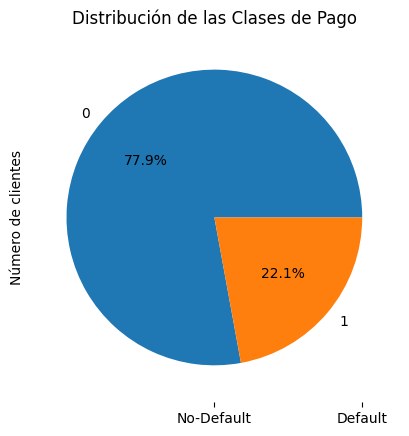

In [ ]:
labels = "0", "1"
sizes = [23364, 6636]
fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, autopct = "%1.1f%%")
plt.title("Distribución de las Clases de Pago")
plt.xticks([0,1], ["No-Default", "Default"])
plt.ylabel("Número de clientes")

## Distribución de cantidad saldo y edades por tipo de DEFAULT:

Observamos una diferencia en la cantidad de saldo que mantienen las personas de Default y No-Default, las que no suelen pagar su deuda a tiempo tienen mayor saldo a pagar que las que sí son pagaderas puntuales.
Por otro lado, existe una mayor cantidad de poseedores de tarjetas de crédito alrededor de los 30 años, pero se nota una ligera superioridad en cantidad entre los No-defaulters.

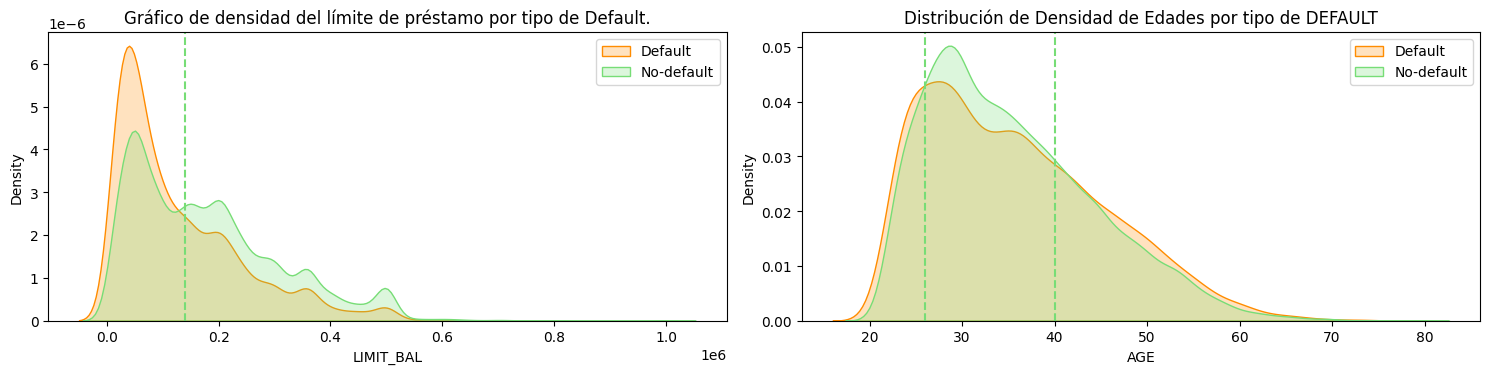

In [ ]:
sns.set_palette(palette=['#77DD76','#FF6962'])
fig, axs = plt.subplots(1, 2, figsize=(15,4))

clase_0 = df.loc[df['DEFAULT'] == 0]['LIMIT_BAL']
clase_1 = df.loc[df['DEFAULT'] == 1]['LIMIT_BAL']
axs[0].set_title('Gráfico de densidad del límite de préstamo por tipo de DEFAULT.')
sns.kdeplot(clase_1, fill=True, label='Default', color='darkorange', ax=axs[0])
sns.kdeplot(clase_0, fill=True, label='No-default', ax=axs[0])
axs[0].axvline(0.14*1e6, 0, ls='--')
axs[0].legend()

clase_0 = df.loc[df['DEFAULT'] == 0]['AGE']
clase_1 = df.loc[df['DEFAULT'] == 1]['AGE']
axs[1].set_title('Distribución de Densidad de Edades por tipo de DEFAULT')
sns.kdeplot(clase_1, fill=True, label='Default', color='darkorange', ax=axs[1])
sns.kdeplot(clase_0, fill=True, label='No-default', ax=axs[1])
axs[1].axvline(26, 0, ls='--')
axs[1].axvline(40, 0, ls='--')
axs[1].legend()

plt.tight_layout()
plt.show()

A continuación también se añaden gráficos de barras indicando la distribución del tipo de Default (no-pago o pago) correpondientes a cada sexo, a cada nivel educativo y a cada estado civil.
Se rescata que hay más mujeres con tarjetas de crédito, predominancia también observada en aquellos con estudios universitarios y en las personas solteras. De todos estos se mantiene la etiqueta de "DEFAULT", lo que quiere decir que no realizaron el pago a tiempo.

/tmp/ipython-input-4101294855.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Varón', 'Mujer'])
/tmp/ipython-input-4101294855.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Institutos', 'Universidad', 'Escuela Secundaria', 'Otros'])
/tmp/ipython-input-4101294855.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(['Casad@', 'Solter@', 'Otros'])


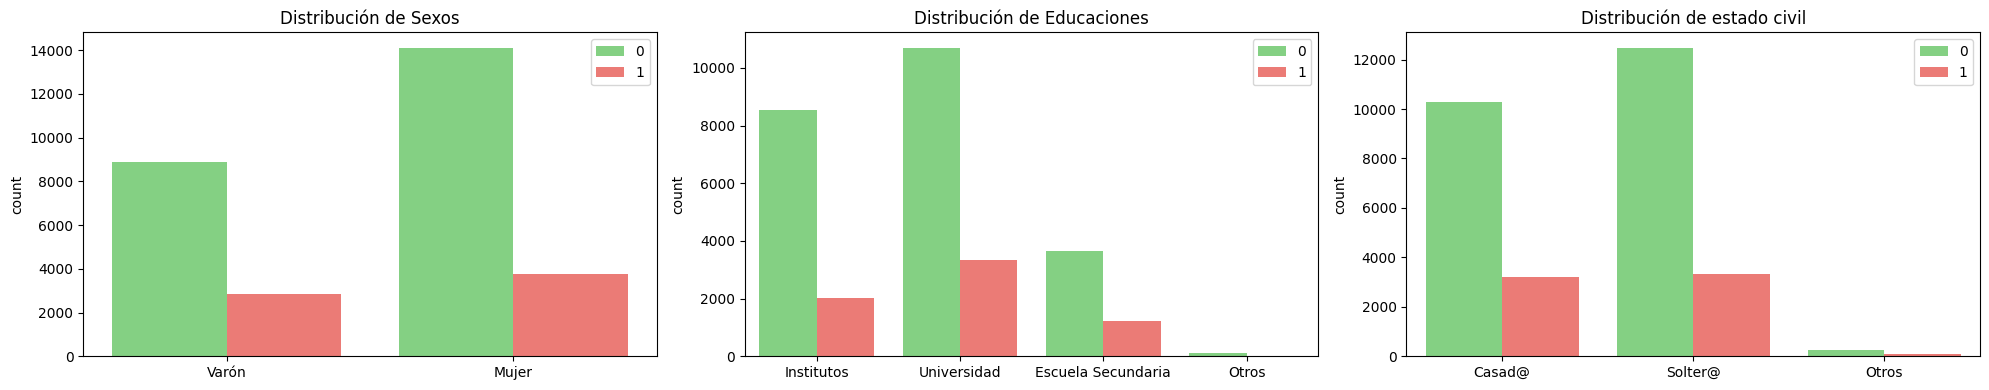

In [ ]:
sns.set_palette(palette=['#77DD76','#FF6962'])
fig, axs = plt.subplots(1, 3, figsize=(20,4))

axs[0].set_title('Distribución de Sexos')
sns.countplot(x='SEX', hue='DEFAULT', data=df, ax=axs[0])
axs[0].set_xticklabels(['Varón', 'Mujer'])
axs[0].set_xlabel('')
axs[0].legend()

axs[1].set_title('Distribución de Educaciones')
sns.countplot(x='EDUCATION', hue='DEFAULT', data=df, ax=axs[1])
axs[1].set_xticklabels(['Institutos', 'Universidad', 'Escuela Secundaria', 'Otros'])
axs[1].set_xlabel('')
axs[1].legend()

axs[2].set_title('Distribución de estado civil')
sns.countplot(x='MARRIAGE', hue='DEFAULT', data=df, ax=axs[2])
axs[2].set_xticklabels(['Casad@', 'Solter@', 'Otros'])
axs[2].set_xlabel('')
axs[2].legend()

fig.tight_layout()
plt.show()

A continuación se observan las variables PAY_i, donde i representa el mes de Septiembre a Abril (en reversa) y el contenido es el número de meses de retraso que tiene en su pago. El valor "-1" indica que se pagó a tiempo.
Aquí observamos que es habitual que exista una retraso de dos meses en el pagar de deudas, y un decrecimiento importante al llegar al tercer mes (los siguientes decrecimientos no son tan pronunciados. Asimismo notamos que el número máximo de meses de tardanza en el pago suele ser de cuatro meses.

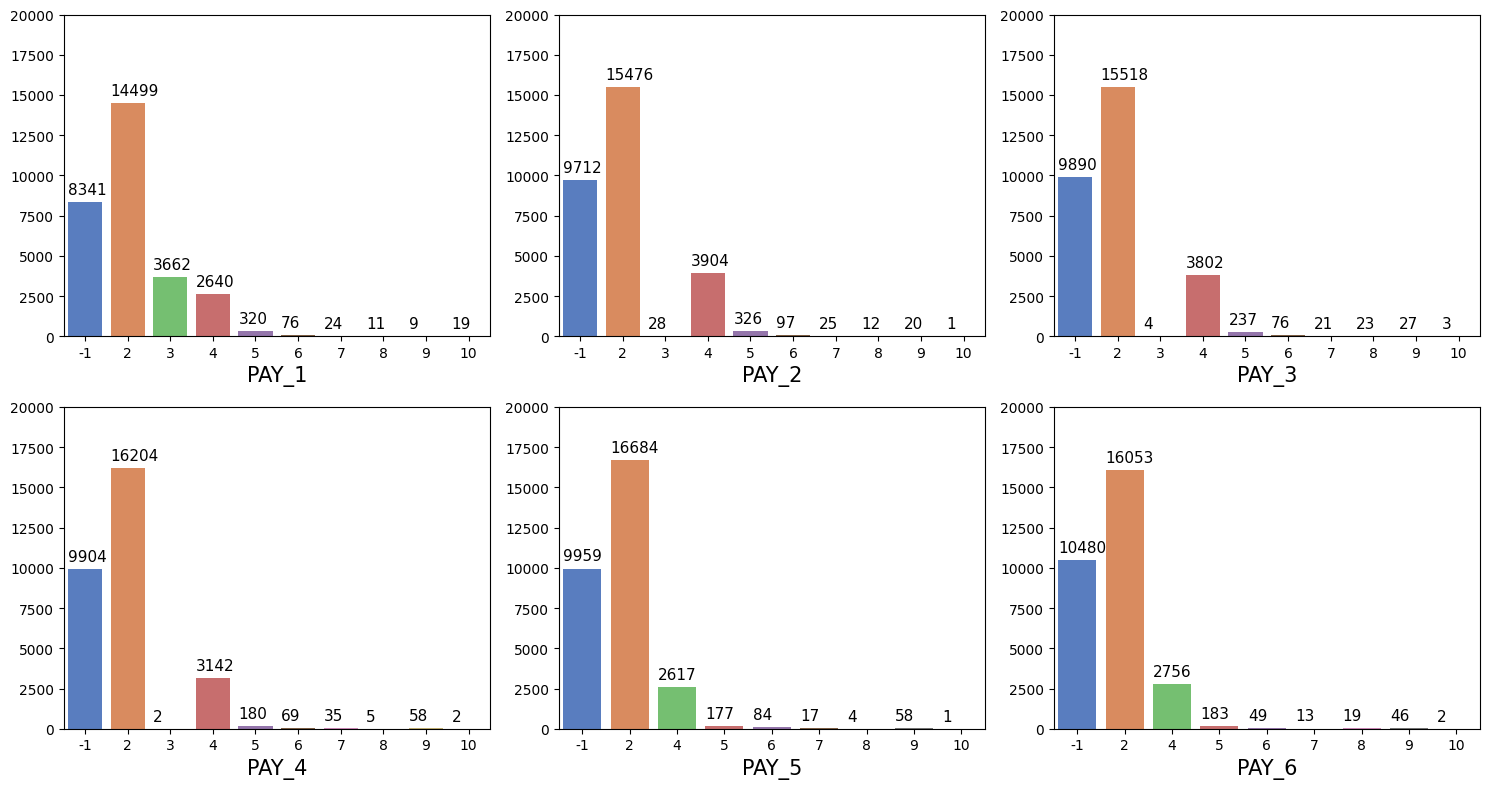

In [ ]:
PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize=(15, 8))

for i, col in enumerate(PAY_cols):
    plt.subplot(2, 3, i + 1)
    ax = sns.countplot(x=col, hue=col, data=df, palette='muted', legend=False)

    plt.ylim(0, 20000)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('')
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x(), p.get_height() + 500),
                    fontsize=11)

plt.show()

A continuación se observa la deuda pendiente en cada uno de los meses, con diferenciación entre los dos estados de Default.

/tmp/ipython-input-3309374772.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default',color='#77DD76', shade=True)
/tmp/ipython-input-3309374772.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', color='#FF6962', shade=True)
/tmp/ipython-input-3309374772.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default',color='#77DD76', shade=True)
/tmp/ipython-input-3309374772.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will

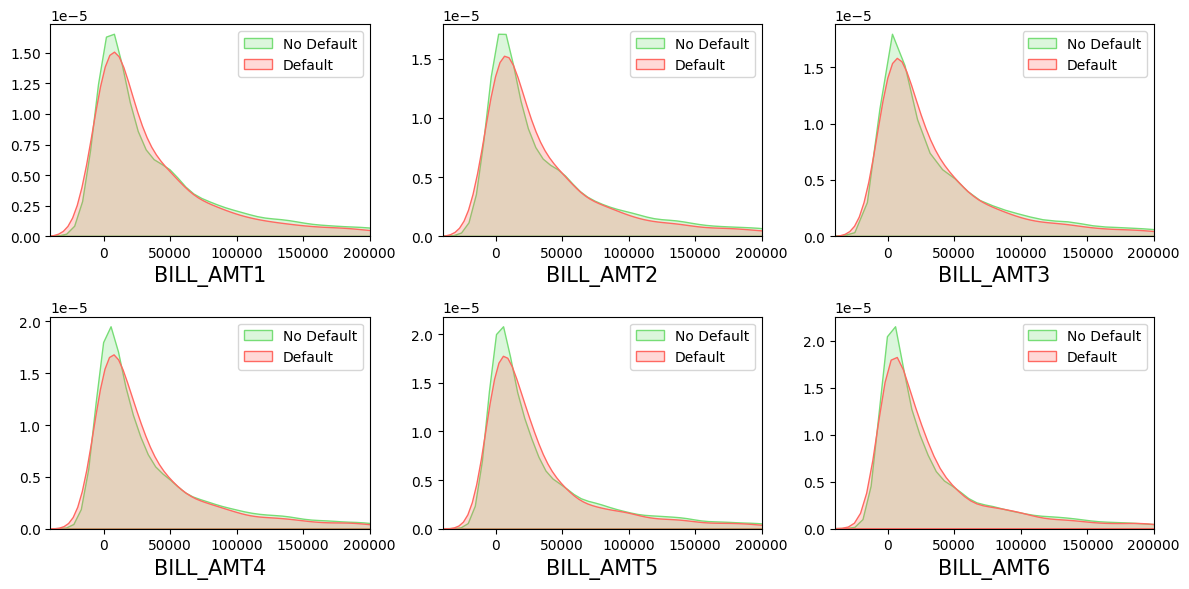

In [ ]:
BILL_AMT_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(12,6))

for i,col in enumerate(BILL_AMT_cols):
    plt.subplot(2,3,i + 1)
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default',color='#77DD76', shade=True)
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', color='#FF6962', shade=True)
    plt.xlim(-40000,200000)
    plt.ylabel('')
    plt.xlabel(col,fontsize=15)
    plt.legend()
    plt.tight_layout()

plt.show()

Por el contrario, a continuación se encuentra la cantidad de pagos realizados en cada uno de los meses de estudio, también separados por clase de default

/tmp/ipython-input-2665550275.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default', shade = True,color='#77DD76')
/tmp/ipython-input-2665550275.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', shade = True, color='#FF6962')
/tmp/ipython-input-2665550275.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default', shade = True,color='#77DD76')
/tmp/ipython-input-2665550275.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
Thi

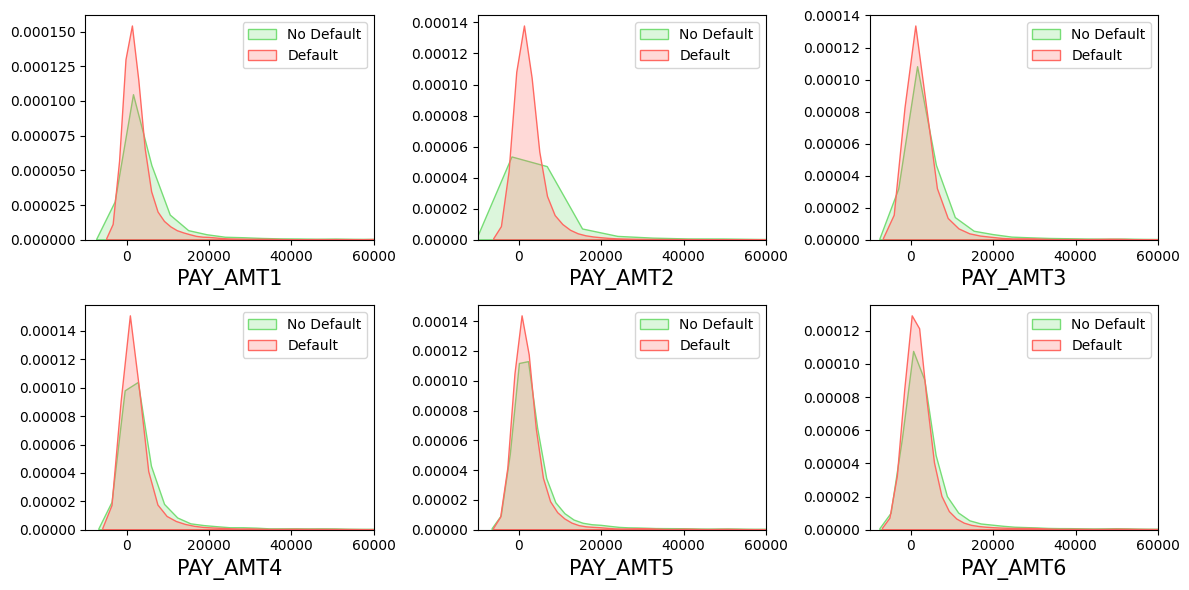

In [ ]:
# Suma de pagos realizados separado por clase

PAY_AMT_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(12,6))

for i,col in enumerate(PAY_AMT_cols):
    plt.subplot(2,3,i + 1)
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default', shade = True,color='#77DD76')
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', shade = True, color='#FF6962')
    plt.xlim(-10000,60000)
    plt.xlabel(col,fontsize=15)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
0,1,20000,24,4,4,-1,-1,-1,-1,3913,3102,689,0,0,0,0,689,0,0,0,0,1,False,True,False,False,True
1,2,120000,26,-1,4,2,2,2,4,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,False,True,False,False,False
2,3,90000,34,2,2,2,2,2,2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,False,True,False,False,False
3,4,50000,37,2,2,2,2,2,2,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,False,True,False,False,True
4,5,50000,57,-1,2,-1,2,2,2,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,False,True,False,True,True


# Correlación

A continuación se realiza el análisis de correlación correspondiente en cualquier EDA para determinar esta importante característica. La primera observación se centra en la agrupación de sectores numéricos para cada set de variables, es decir, las variables PAY_i tienen correlación alta entre ellas mismas, igual que con BILL_AMTi y PAY_AMTi.

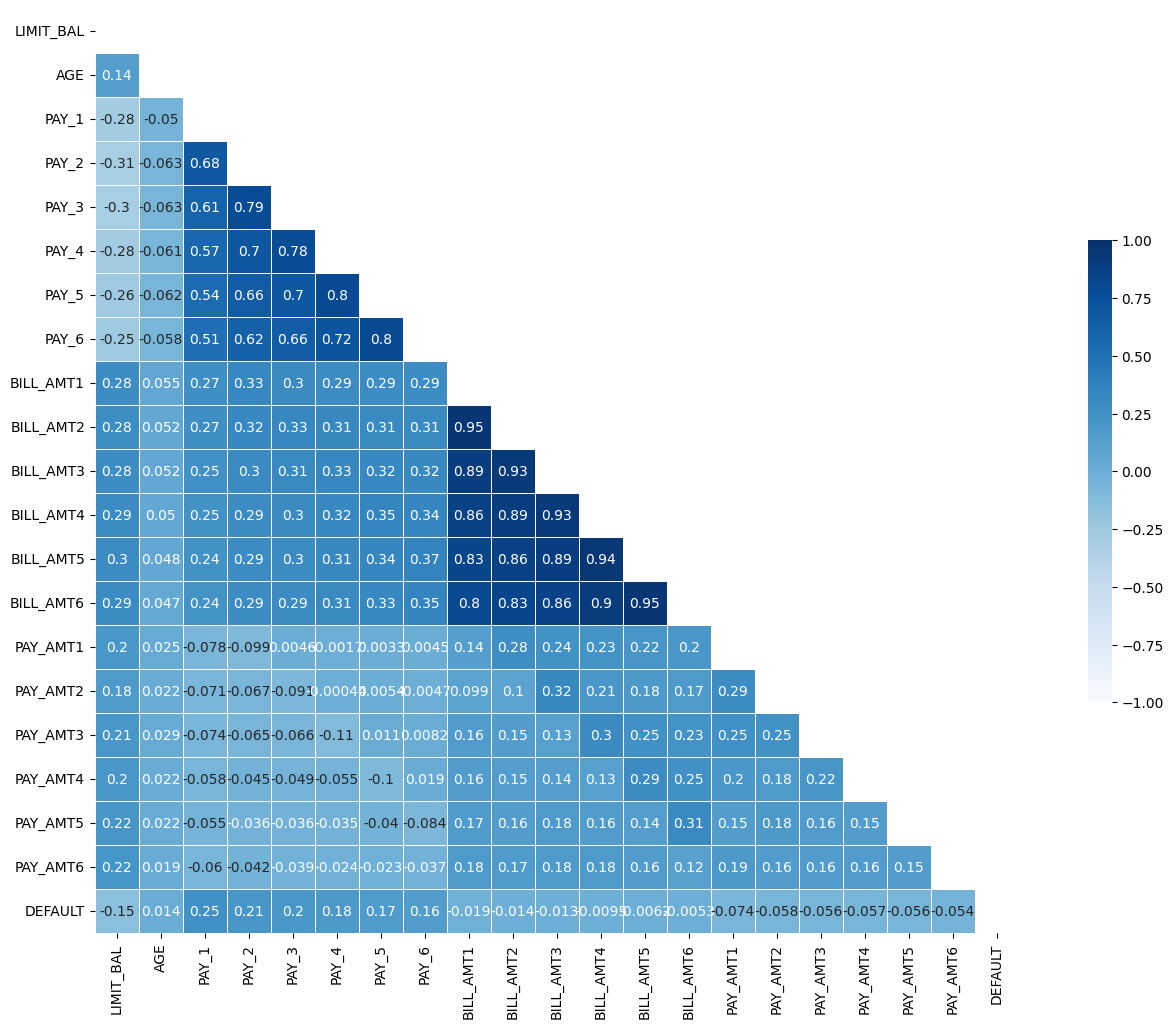

In [ ]:
numeric = ['LIMIT_BAL','AGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6', 'DEFAULT']
corr = df[numeric].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': .5}, annot=True, annot_kws={'size': 10})
cbar = ax.collections[0].colorbar

# Pre-procesamiento:

## Manejando categorización de variables

Para continuar, se realiza un ajuste con respecto a las variables categóricas. Se tienen muchos datos cuya información está representada por variables numéricas, que en verdad representan una categoría para la variable en cuestión, por lo que se recurre al siguiente código. Además, el mismo dividirá las variables de manera más óptima, como por ejemplo, dividiento la variable SEX en una variable MALE que indique 1 y 0 para verdadero o falso, indicadores para UNIVERITY y HIGH_SCHOOL que sirven como variables indicadoras, y lo propio para la variable MARRIED.

In [ ]:
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category')
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category')
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category')
df.drop('EDUCATION', axis=1, inplace=True)

df['MALE'] = (df['SEX'] == 1).astype('category')
df.drop('SEX', axis=1, inplace=True)

df['MARRIED'] = (df['MARRIAGE'] == 1).astype('category')
df.drop('MARRIAGE', axis=1, inplace=True)

df.head()

## División del dataset:

Se realiza una división en proporción 3:1, utilizando el random_state = 24 para replicabilidad.

In [ ]:
y = df['DEFAULT']
X = df.drop('DEFAULT', axis=1, inplace=False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)
print('Entrenando: ', np.shape(X_train_raw))
print(f'- Default:\t {len(y_train[y_train==1])}')
print(f'- No-default: {len(y_train[y_train==0])}')
print('Prueba: ', np.shape(X_test_raw))
print(f'- Default:\t {len(y_test[y_test==1])}')
print(f'- No-default: {len(y_test[y_test==0])}')

Entrenando:  (22200, 26)
- Default:	 4954
- No-default: 17246
Prueba:  (7401, 26)
- Default:	 1651
- No-default: 5750


## Escalado de datos

Con el propósito de brindar al algoritmo una mayor eficiencia, se realiza el escalado de datos. Se realiza en esta ocasión una comparativa entre la normalización y la estandarización.
Esto será relevante posteriormente, ya que dependiendo del algoritmo utilizado, el método puede impactar en el rendimiento del modelo: la normalización permite mitigar el efecto de outliers, mientras que la estandarización mantiene la información de los datos.

/tmp/ipython-input-1842823493.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=numeric, rotation=25)
/tmp/ipython-input-1842823493.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=numeric, rotation=25)


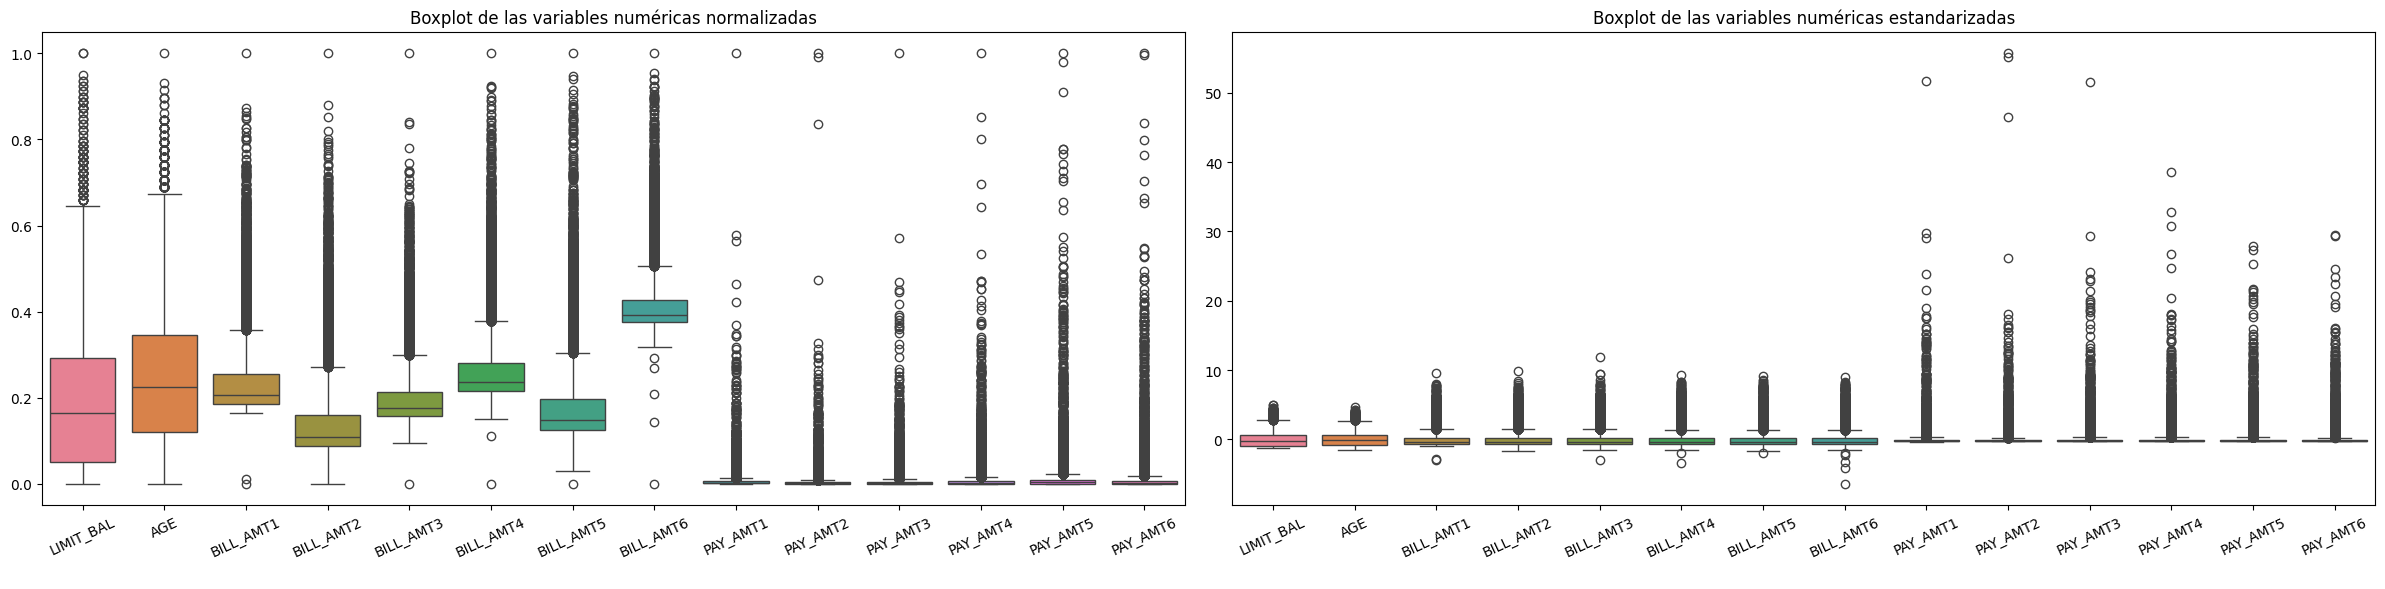

In [ ]:
scaler = MinMaxScaler()
X_train_norm = X_train_raw.copy()
X_test_norm = X_test_raw.copy()

X_train_norm['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_test_norm['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_train_norm['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1))
X_test_norm['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    X_train_norm['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_train_norm['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_train_norm['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))

scaler = StandardScaler()
X_train_std = X_train_raw.copy()
X_test_std = X_test_raw.copy()

X_train_std['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_test_std['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_train_std['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1))
X_test_std['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    X_train_std['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_std['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_train_std['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_std['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_train_std['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_std['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))

sns.set_color_codes('deep')
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
fig, axs = plt.subplots(1, 2, figsize=(24,6))

sns.boxplot(data=X_train_norm[numeric], ax=axs[0])
axs[0].set_title('Boxplot de las variables numéricas normalizadas')
axs[0].set_xticklabels(labels=numeric, rotation=25)
axs[0].set_xlabel(' ')

sns.boxplot(data=X_train_std[numeric], ax=axs[1])
axs[1].set_title('Boxplot de las variables numéricas estandarizadas')
axs[1].set_xticklabels(labels=numeric, rotation=25)
axs[1].set_xlabel(' ')

fig.tight_layout()
plt.show()

## Reducción de dimensionalidad:

### Análisis de Componentes Principales
El análisis de componentes principales es un procedimiento ya conocido. Su funcionalidad recae en reducir la cantidad de variables creando nuevos componentes que expliquen la variabilidad de los datos, de los cuales quien estudia el conjunto de datos se verá en la disyuntiva de cuántos componentes principales mantener. Esto es sobre todo aplicable en conjuntos con una alta correlación.
En el gráfico inferior se observa la varianza explicada de los componentes (hasta 25 componentes).
El resultado obtenido es que a partir del tercer o cuarto componente (aproximadamente), el aumento de varianza explicada empieza a disminuir. De un aumento de más del 10% se reduce a un 6% y descendiendo. Para este estudio, se optó por la selección de 8 componentes, ya que gráficamente y numéricamente el aumento se vuelve mínimo, y se evita overfitting. Es de notar que para la realización de la red neuronal posterior, se optó por la utilización de todas las variables, mientras que el PCA solo se está abordando de manera exploratoria.


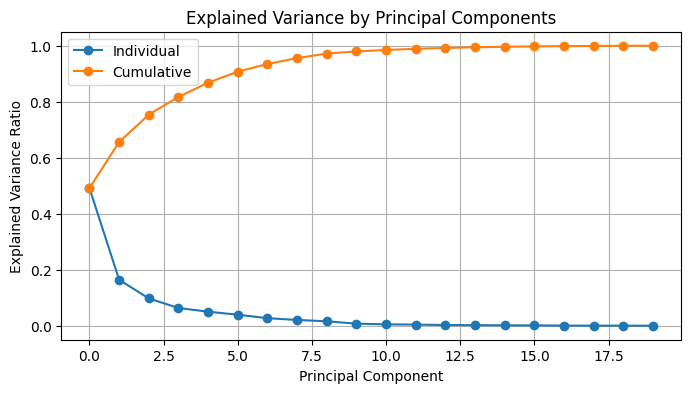

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Cumulative Explained Variance,49.17%,65.61%,75.39%,81.75%,86.80%,90.76%,93.48%,95.58%,97.19%,97.96%,98.48%,98.91%,99.21%,99.44%,99.62%


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

numeric_cols = [
    'LIMIT_BAL', 'AGE',
    'PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'
]

scaler = MinMaxScaler()
X_train_norm = X_train_raw.copy()
X_test_norm = X_test_raw.copy()

X_train_norm[numeric_cols] = scaler.fit_transform(X_train_raw[numeric_cols])
X_test_norm[numeric_cols] = scaler.transform(X_test_raw[numeric_cols])

pca = PCA()
pca.fit(X_train_norm[numeric_cols])

plt.figure(figsize=(8,4))
plt.plot(pca.explained_variance_ratio_, marker='o', label='Individual')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Cumulative')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

cumsum = np.cumsum(pca.explained_variance_ratio_)
pc = len(pca.explained_variance_ratio_)

indexes = [f'PC{i}' for i in range(1, pc + 1)]

cumsum_df = pd.DataFrame({
    'Cumulative Explained Variance': [f"{val * 100:.2f}%" for val in cumsum]
}, index=indexes)

cumsum_df.T.iloc[:, :15]
